# Práctica Calificada 1 - Grupo 2: Modelado de Series de Tiempo

**Objetivo:** Este notebook contiene los experimentos de modelado para predecir la demanda de productos, utilizando modelos estadísticos, de machine learning y de deep learning.

## 1. Carga de Librerías y Datos

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15, 8)

print("Librerías cargadas exitosamente.")

Librerías cargadas exitosamente.


### 1.1. Cargar Datos Procesados y Seleccionar un Producto

Cargamos los datos agregados por día y producto que preparamos en el notebook anterior. Para simplificar el modelado inicial, seleccionaremos el producto con el mayor ingreso total y construiremos un pipeline de modelos para esa única serie de tiempo.

In [2]:
# Definir el path y cargar los datos
project_root = Path().resolve().parents[0]
PROCESSED_DATA_PATH = project_root / 'data' / 'processed' / 'group2_data.parquet'
df = pd.read_parquet(PROCESSED_DATA_PATH)

# Asegurarse que la fecha sea el tipo correcto
df["transaction_date"] = pd.to_datetime(df["transaction_date"])

# Calcular el producto con mayor ingreso total
top_products = df.groupby('product_sku')["total_product_revenue_usd"].sum().nlargest(10)
top_product_sku = top_products.index[0]

print("Top 10 productos por ingresos totales:")
print(top_products)
print(f"\nSeleccionando el producto con mayor ingreso para el modelado: {top_product_sku}")

# Filtrar el DataFrame para obtener la serie de tiempo de un solo producto
ts_one_product = df[df["product_sku"] == top_product_sku].copy()
ts_one_product.set_index('transaction_date', inplace=True)
ts_one_product = ts_one_product.asfreq('D').fillna(0) # Asegurar frecuencia diaria

print(f"\nForma del dataset para el producto seleccionado: {ts_one_product.shape}")
ts_one_product.head()

Top 10 productos por ingresos totales:
product_sku
GGOEGDHQ015399    44454.491527
GGOEGOCB017499    38563.457656
GGOEGOLC014299    30651.894191
GGOEGDHC018299    29221.952345
GGOEGOCL077699    25432.673189
GGOEGBMJ013399    23562.293008
GGOEGDHC074099    23301.667771
GGOEGBRA037499    19563.927964
GGOEYOLR018699    18769.614525
GGOEGBRJ037399    18448.335839
Name: total_product_revenue_usd, dtype: float64

Seleccionando el producto con mayor ingreso para el modelado: GGOEGDHQ015399

Forma del dataset para el producto seleccionado: (366, 5)


,product_sku,total_product_quantity,total_product_revenue_usd,avg_product_price_usd,total_transactions
transaction_date,,,,,
2016-08-01,GGOEGDHQ015399,26.0,520.073333,19.990000,1.0
2016-08-02,0,0.0,0.000000,0.000000,0.0
2016-08-03,0,0.0,0.000000,0.000000,0.0
2016-08-04,0,0.0,0.000000,0.000000,0.0
2016-08-05,GGOEGDHQ015399,4.0,96.360000,21.656667,3.0


## 2. Análisis Exploratorio de la Serie de Tiempo del Producto

Ahora que hemos seleccionado un producto, realizaremos un análisis exploratorio de su serie de tiempo. Nos enfocaremos en la cantidad total de productos vendidos (`total_product_quantity`) como nuestra variable objetivo para predecir la demanda.

Visualizaremos la serie, la descompondremos en sus componentes (tendencia, estacionalidad, residuo) y realizaremos un test de estacionariedad para entender mejor su comportamiento.

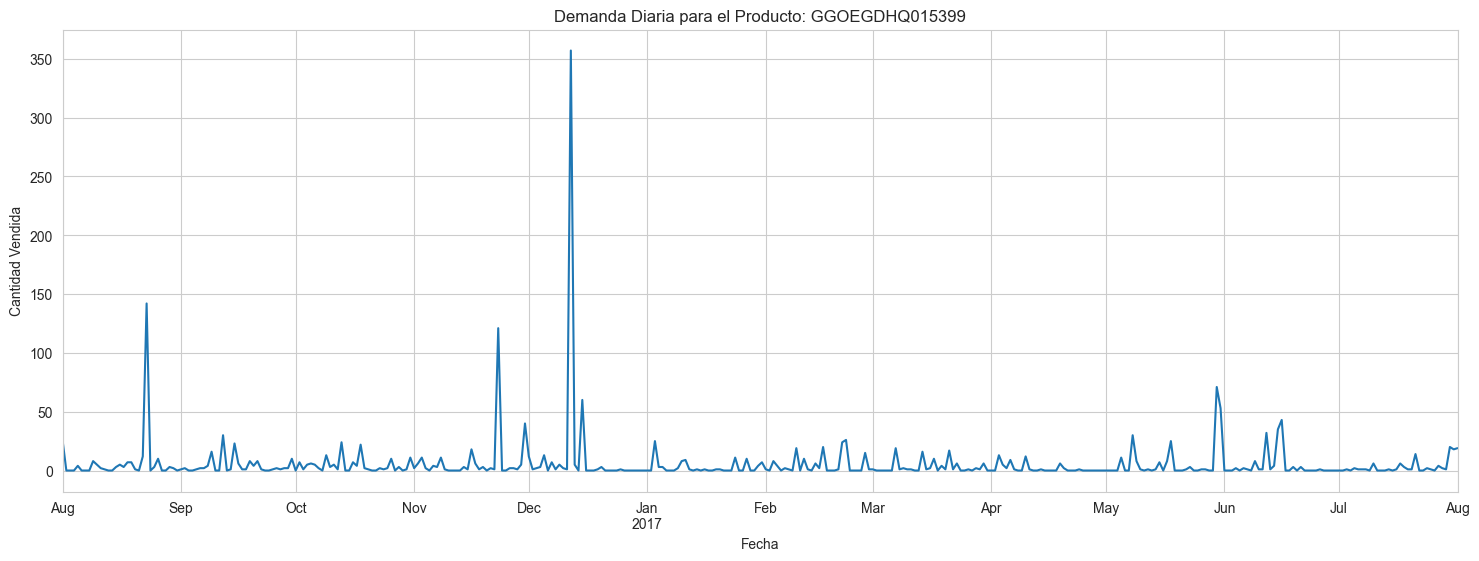

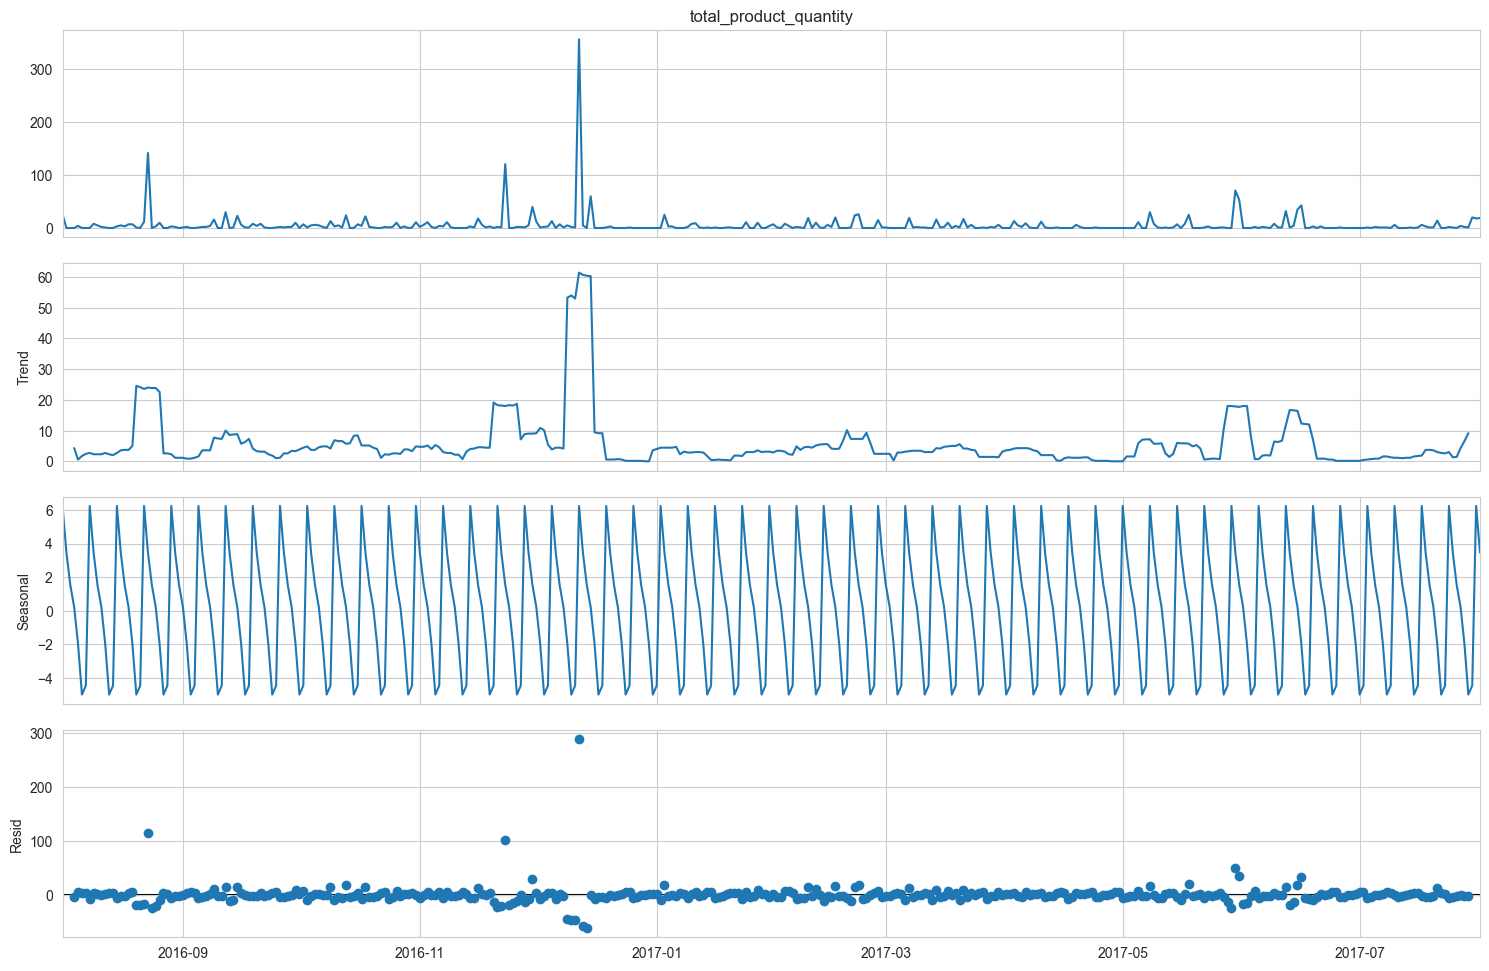

Resultados del Test de Dickey-Fuller para Demanda de GGOEGDHQ015399:
--------------------------------------------------
Estadístico ADF           -9.973288e+00
p-value                    2.211194e-17
Lags utilizados            2.000000e+00
Número de observaciones    3.630000e+02
Valor crítico (1%)        -3.448494e+00
Valor crítico (5%)        -2.869535e+00
Valor crítico (10%)       -2.571029e+00
dtype: float64

✅ RESULTADO: Rechazamos H0 (p-value: 0.0000). La serie ES ESTACIONARIA.


In [3]:
# Seleccionar la variable objetivo
target_col = 'total_product_quantity'
ts = ts_one_product[target_col]

# 1. Visualizar la serie de tiempo
plt.figure(figsize=(18, 6))
ts.plot(title=f'Demanda Diaria para el Producto: {top_product_sku}')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Vendida')
plt.show()

# 2. Descomposición de la serie de tiempo
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

# Asumimos una estacionalidad semanal (period=7)
decomposition = sm.tsa.seasonal_decompose(ts, model='additive', period=7)

fig = decomposition.plot()
fig.set_size_inches(15, 10)
plt.show()

# 3. Test de Estacionariedad (Augmented Dickey-Fuller)
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries, title=''):
    print(f'Resultados del Test de Dickey-Fuller para {title}:')
    print('-' * 50)
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=[
        'Estadístico ADF',
        'p-value',
        'Lags utilizados',
        'Número de observaciones'
    ])
    for key, value in dftest[4].items():
        dfoutput[f'Valor crítico ({key})'] = value
    print(dfoutput)
    print()
    if dftest[1] <= 0.05:
        print(f"\u2705 RESULTADO: Rechazamos H0 (p-value: {dftest[1]:.4f}). La serie ES ESTACIONARIA.")
    else:
        print(f"\u274c RESULTADO: No rechazamos H0 (p-value: {dftest[1]:.4f}). La serie NO ES ESTACIONARIA.")

adf_test(ts, f'Demanda de {top_product_sku}')

### 2.1. Análisis de Autocorrelación (ACF y PACF)

Para ayudarnos a determinar los parámetros del modelo SARIMA, analizaremos las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF) de nuestra serie.

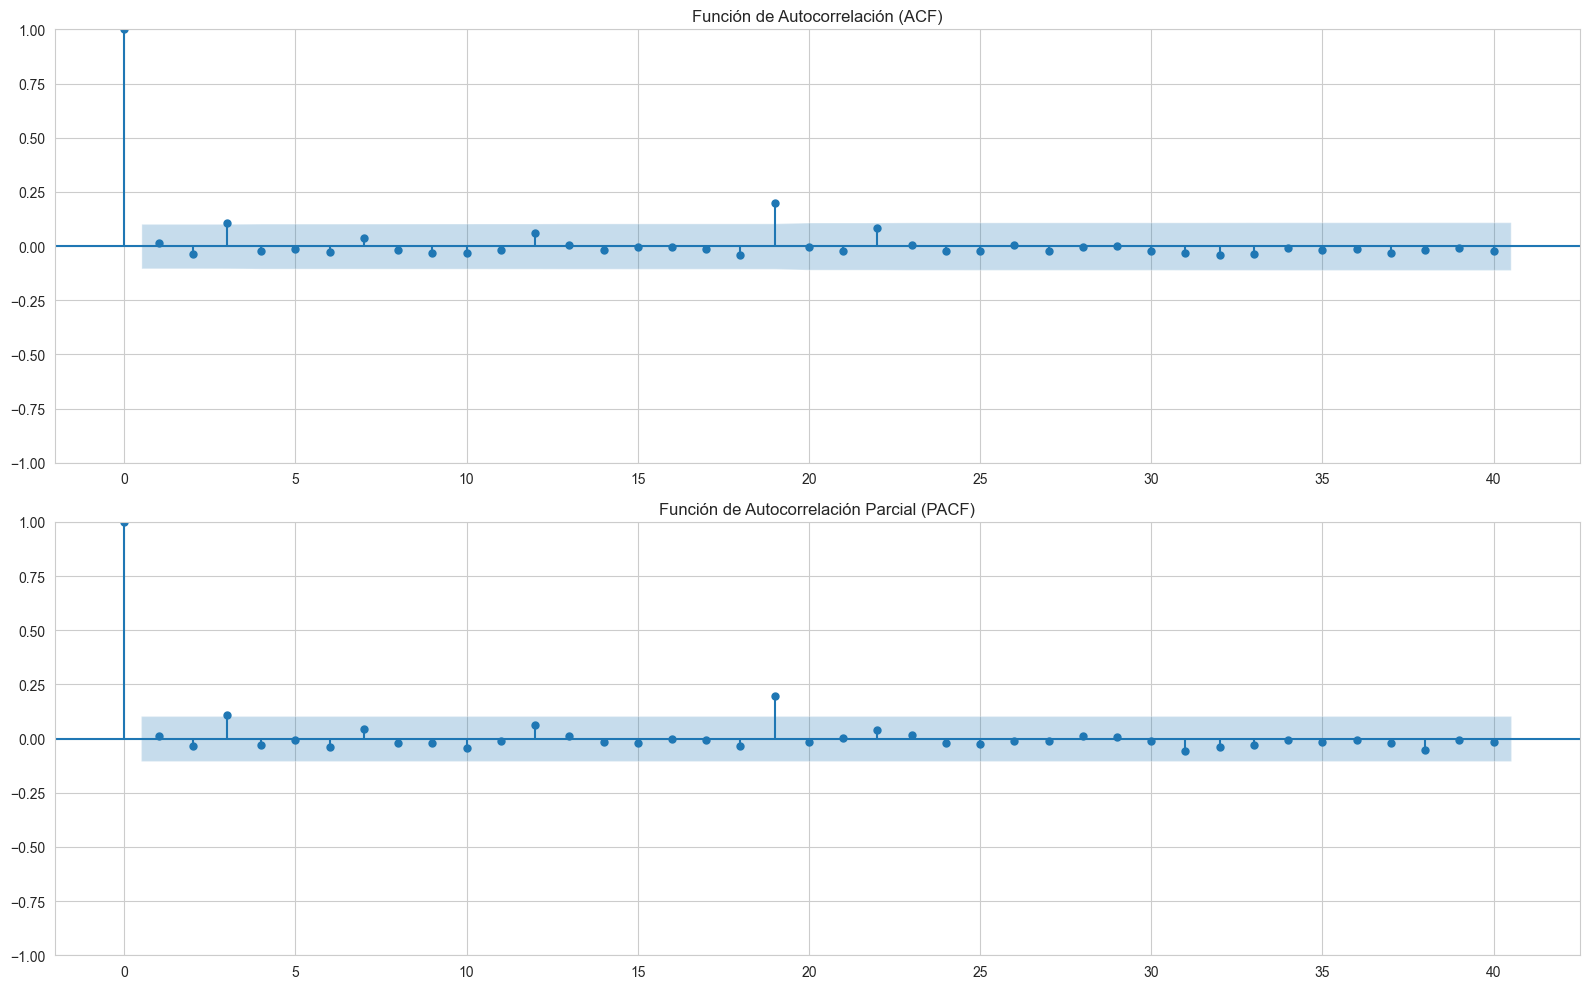

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Graficar ACF y PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# ACF
plot_acf(ts, lags=40, ax=ax1)
ax1.set_title('Función de Autocorrelación (ACF)')

# PACF
plot_pacf(ts, lags=40, ax=ax2)
ax2.set_title('Función de Autocorrelación Parcial (PACF)')

plt.tight_layout()
plt.show()

## 3. Modelado Estadístico: SARIMA

Comenzamos con nuestro primer modelo: SARIMA (Seasonal AutoRegressive Integrated Moving Average). Este es un modelo estadístico potente que es bueno para capturar la estacionalidad en los datos.

El proceso será:
1. Dividir los datos en conjuntos de entrenamiento y prueba.
2. Realizar una búsqueda de los mejores parámetros para el modelo.
3. Entrenar el modelo SARIMA con los mejores parámetros encontrados.
4. Evaluar el modelo en el conjunto de prueba.

Tamaño del set de entrenamiento: 329
Tamaño del set de prueba: 37

Iniciando búsqueda de parámetros para SARIMA...
Mejor SARIMA(1, 0, 1)x(0, 1, 1, 7) - AIC:2894.2787872704657

Entrenando el mejor modelo encontrado...
                                     SARIMAX Results                                     
Dep. Variable:            total_product_quantity   No. Observations:                  329
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -1443.139
Date:                           Wed, 01 Oct 2025   AIC                           2894.279
Time:                                   16:47:22   BIC                           2909.264
Sample:                               08-01-2016   HQIC                          2900.267
                                    - 06-25-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.

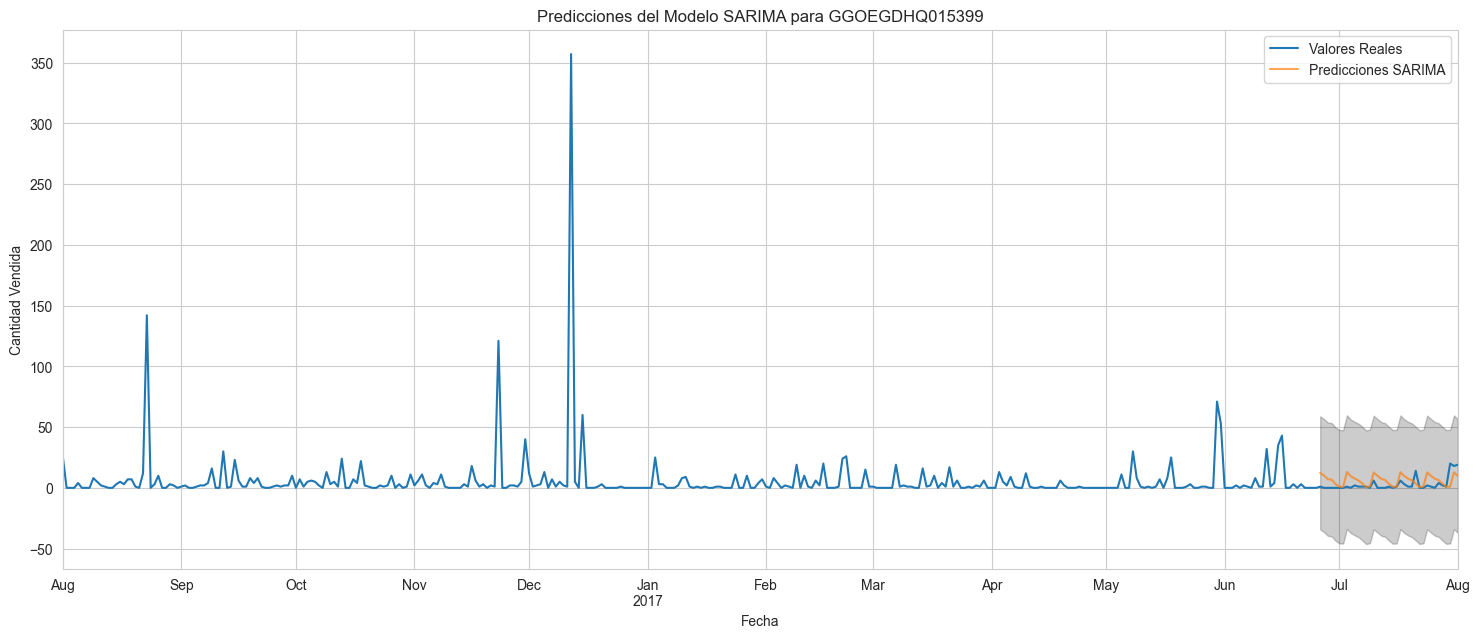

In [5]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore") # Ignorar advertencias de convergencia

# 1. Dividir datos en train/test
train_size = int(len(ts) * 0.9)
train, test = ts[0:train_size], ts[train_size:]
print(f"Tamaño del set de entrenamiento: {len(train)}")
print(f"Tamaño del set de prueba: {len(test)}")

# 2. Búsqueda de parámetros (Grid Search)
# Definimos los rangos para p, d, q
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
# Definimos los rangos para P, D, Q estacionales (con m=7)
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

print("\nIniciando búsqueda de parámetros para SARIMA...")
best_aic = float("inf")
best_pdq = None
best_seasonal_pdq = None
best_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            results = mod.fit(disp=False)
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = results
                
        except:
            continue

print(f"Mejor SARIMA{best_pdq}x{best_seasonal_pdq} - AIC:{best_aic}\n")

# 3. Entrenar el mejor modelo y hacer predicciones
print("Entrenando el mejor modelo encontrado...")
# El best_model ya está entrenado, pero lo mostramos para claridad
print(best_model.summary())

print("\nHaciendo predicciones en el set de prueba...")
pred = best_model.get_prediction(start=pd.to_datetime(test.index[0]), end=pd.to_datetime(test.index[-1]), dynamic=False)
pred_ci = pred.conf_int()

# 4. Evaluar el modelo
y_forecasted = pred.predicted_mean
y_truth = test
mae = mean_absolute_error(y_truth, y_forecasted)
rmse = np.sqrt(mean_squared_error(y_truth, y_forecasted))
print(f'\nError Absoluto Medio (MAE): {mae:.2f}')
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}')

# 5. Visualizar resultados
plt.figure(figsize=(18, 7))
ax = ts.plot(label='Valores Reales')
y_forecasted.plot(ax=ax, label='Predicciones SARIMA', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Cantidad Vendida')
plt.title(f'Predicciones del Modelo SARIMA para {top_product_sku}')
plt.legend()
plt.show()

## 4. Modelado de Machine Learning: XGBoost

Ahora, abordaremos el problema utilizando un modelo de Machine Learning. Usaremos **XGBoost (Extreme Gradient Boosting)**, un algoritmo muy potente y popular.

A diferencia de los modelos estadísticos, los modelos de ML como XGBoost no entienden inherentemente el orden secuencial de los datos. Por lo tanto, debemos transformar nuestro problema de serie de tiempo en un problema de regresión supervisada. Esto lo hacemos a través de la **ingeniería de características (feature engineering)**, donde creamos variables explícitas que capturen la información temporal.

El proceso será:
1. **Ingeniería de Características**: Crear variables basadas en la fecha (cíclicas, día de la semana) y en valores pasados (lags, promedios móviles).
2. **Preparación de Datos**: Dividir el dataset en features (X) y variable objetivo (y).
3. **Entrenamiento del Modelo**: Entrenar un `XGBRegressor`.
4. **Evaluación y Visualización**: Evaluar el rendimiento y visualizar la importancia de las características.

Entrenando modelo XGBoost...
[0]	validation_0-rmse:23.11622	validation_1-rmse:6.14187
[50]	validation_0-rmse:18.19542	validation_1-rmse:8.06838

Error Absoluto Medio (MAE) con XGBoost: 5.48
Raíz del Error Cuadrático Medio (RMSE) con XGBoost: 6.14


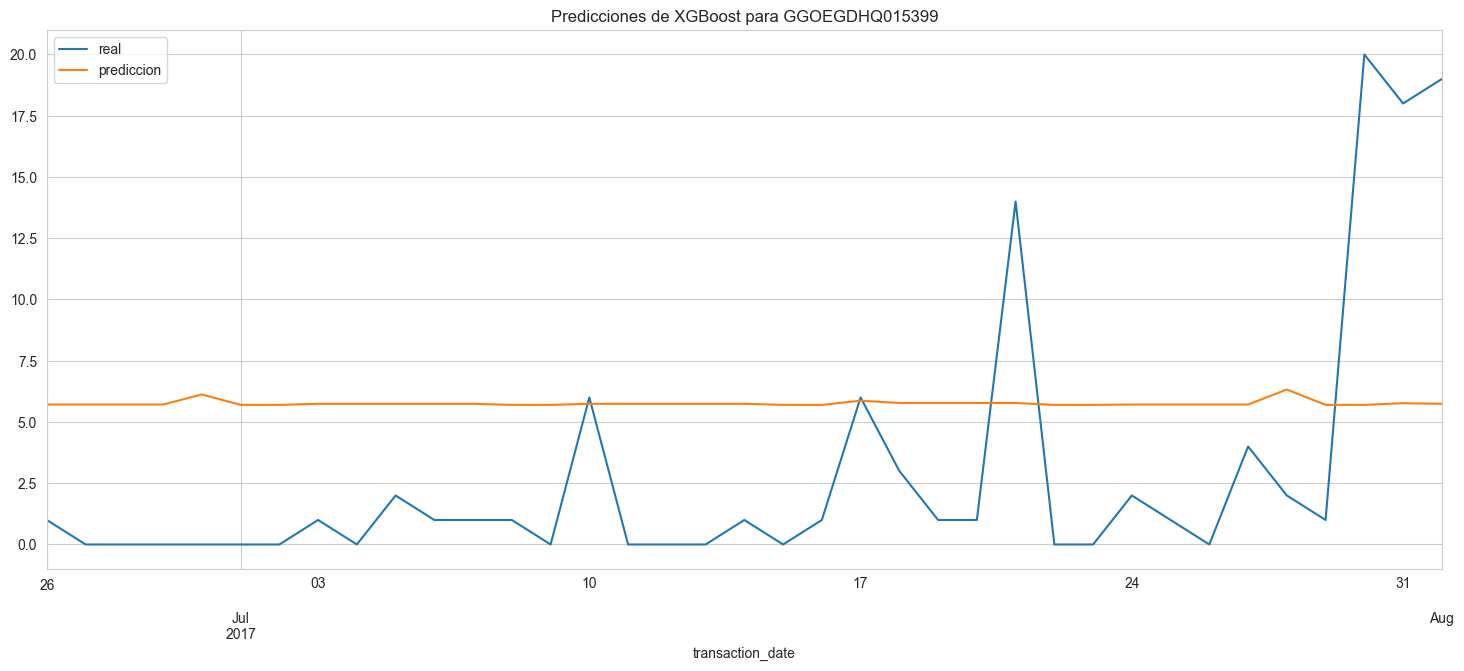

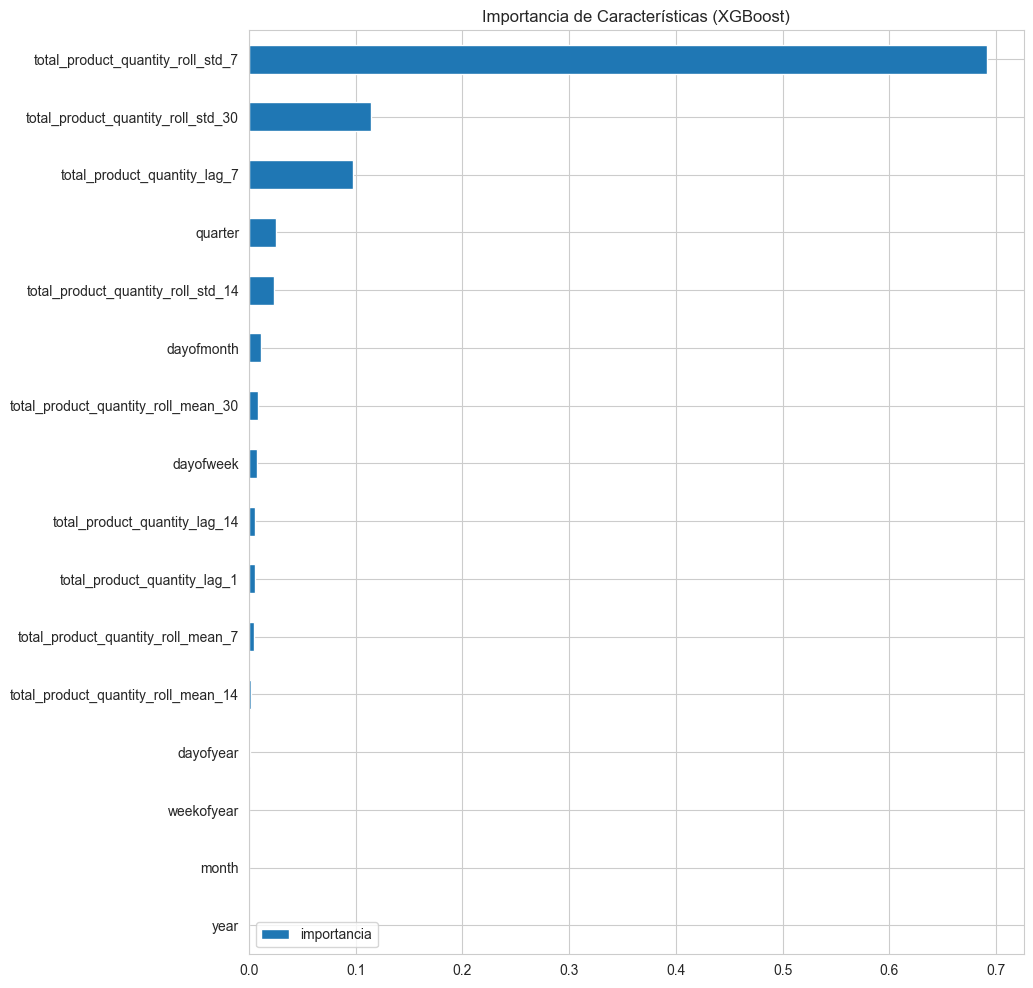

In [6]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# --- 1. Ingeniería de Características ---
def create_time_features(df):
    df_feat = df.copy()
    df_feat['dayofweek'] = df_feat.index.dayofweek
    df_feat['quarter'] = df_feat.index.quarter
    df_feat['month'] = df_feat.index.month
    df_feat['year'] = df_feat.index.year
    df_feat['dayofyear'] = df_feat.index.dayofyear
    df_feat['dayofmonth'] = df_feat.index.day
    df_feat['weekofyear'] = df_feat.index.isocalendar().week.astype(int)
    return df_feat

def create_lag_features(df, target_col, lags):
    df_lag = df.copy()
    for lag in lags:
        df_lag[f'{target_col}_lag_{lag}'] = df_lag[target_col].shift(lag)
    return df_lag

def create_rolling_features(df, target_col, windows):
    df_roll = df.copy()
    for window in windows:
        df_roll[f'{target_col}_roll_mean_{window}'] = df_roll[target_col].shift(1).rolling(window=window).mean()
        df_roll[f'{target_col}_roll_std_{window}'] = df_roll[target_col].shift(1).rolling(window=window).std()
    return df_roll

# Aplicar la ingeniería de características
df_featured = create_time_features(ts_one_product[[target_col]])
df_featured = create_lag_features(df_featured, target_col, lags=[1, 7, 14])
df_featured = create_rolling_features(df_featured, target_col, windows=[7, 14, 30])

# Eliminar filas con NaNs generados
df_featured.dropna(inplace=True)

# --- 2. Preparación de Datos ---
X = df_featured.drop(columns=[target_col])
y = df_featured[target_col]

# --- 3. Train/Test Split ---
split_date = test.index[0] # Usar la misma fecha de corte que SARIMA
X_train, X_test = X[X.index < split_date], X[X.index >= split_date]
y_train, y_test = y[y.index < split_date], y[y.index >= split_date]

# --- 4. Entrenamiento del Modelo ---
print("Entrenando modelo XGBoost...")
reg = xgb.XGBRegressor(
    n_estimators=1000,
    early_stopping_rounds=50,
    eval_metric='rmse',
    learning_rate=0.01,
    random_state=42
)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

# --- 5. Evaluación ---
y_pred = reg.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'\nError Absoluto Medio (MAE) con XGBoost: {mae_xgb:.2f}')
print(f'Raíz del Error Cuadrático Medio (RMSE) con XGBoost: {rmse_xgb:.2f}')

# --- 6. Visualización ---
# Gráfico de predicciones
df_pred = pd.DataFrame({'real': y_test, 'prediccion': y_pred})
df_pred.plot(figsize=(18, 7), title=f'Predicciones de XGBoost para {top_product_sku}')
plt.show()

# Gráfico de importancia de características
feature_importance = pd.DataFrame(data=reg.feature_importances_,
                                  index=reg.feature_names_in_,
                                  columns=['importancia'])
feature_importance.sort_values('importancia').plot(kind='barh', figsize=(10, 12), title='Importancia de Características (XGBoost)')
plt.show()